In [37]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, r2_score
import os
from dotenv import load_dotenv
import yfinance as yf
import pandas as pd
import pandas_ta as ta
from scikeras.wrappers import KerasRegressor
# Load environment variables from the .env file
load_dotenv('../.env');

# Data Viz. 
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.ndimage import gaussian_filter
from calendar import monthrange
from calendar import month_name

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

In [2]:
# Specify the stock symbol and the date range
stock_symbol = "MSFT"
start_date = "2013-01-01"
end_date = "2023-12-18"

# Fetch the stock data
apple_cl = yf.download(stock_symbol, start=start_date, end=end_date)

# Display the stock data
apple_cl.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,27.250000,27.730000,27.150000,27.620001,22.574522,52899300
2013-01-03,27.629999,27.650000,27.160000,27.250000,22.272118,48294400
2013-01-04,27.270000,27.340000,26.730000,26.740000,21.855268,52521100
2013-01-07,26.770000,26.879999,26.639999,26.690001,21.814409,37110400
2013-01-08,26.750000,26.790001,26.459999,26.549999,21.699984,44703100


In [3]:
#here we are adding technical indicators to the data set as seperate columns

apple_cl['RSI'] = ta.rsi(apple_cl['Adj Close'], length=15)
apple_cl['EMAF'] = ta.ema(apple_cl['Adj Close'], length=20) #fast moving avg
apple_cl['EMAM'] = ta.ema(apple_cl['Adj Close'], length=100) #medium moving avg
apple_cl['EMAS'] = ta.ema(apple_cl['Adj Close'], length=150) #slow moving avg


apple_cl['target'] = apple_cl['Adj Close'] - apple_cl.Open
apple_cl['target'] = apple_cl['target'].shift(-1)
apple_cl['target_class'] = [1 if apple_cl.target[i]>0 else 0 for i in range(len(apple_cl))]
apple_cl['target_next_close'] = apple_cl['Adj Close'].shift(-1)

apple_cl.dropna(inplace=True)
apple_cl.reset_index(inplace=True)
apple_cl.drop(['Volume' , 'Close', 'Date'], axis=1, inplace=True)


In [4]:
apple_cl.head()

,Open,High,Low,Adj Close,RSI,EMAF,EMAM,EMAS,target,target_class,target_next_close
0,31.549999,31.670000,31.379999,26.207312,36.913558,27.059401,26.526855,25.447614,-4.934347,0,26.605654
1,31.540001,32.099998,31.250000,26.605654,42.200173,27.016187,26.528415,25.462953,-4.945555,0,27.294447
2,32.240002,33.070000,32.049999,27.294447,49.967779,27.042688,26.543584,25.487211,-5.633230,0,27.136770
3,32.770000,32.900002,32.470001,27.136770,48.373338,27.051648,26.555330,25.509059,-5.182156,0,27.277843
4,32.459999,32.970001,32.459999,27.277843,49.905651,27.073190,26.569637,25.532487,-5.574795,0,26.935204


In [5]:
# Stock closing prices are features and date is the date time index

numeric_features = apple_cl[['Open', 'High', 'Low', 'Adj Close', 'RSI', 'EMAF', 'EMAS', 'EMAM']]
targets = apple_cl[['target', 'target_class', 'target_next_close']]

train_size = int(len(apple_cl) * 0.8)
train_features, test_features = numeric_features[:train_size], numeric_features[train_size:]
train_targets, test_targets = targets[:train_size], targets[train_size:]


# Create a preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler(feature_range=(0,1)))
])

# Apply the preprocessing pipeline to numeric features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', preprocessing_pipeline, numeric_features.columns)
    ])

In [6]:
# Fit and transform the training data
train_features_preprocessed = preprocessor.fit_transform(train_features)

# Transform the test data using the learned parameters from the training data
test_features_preprocessed = preprocessor.transform(test_features)

### Reshape the Data

In [7]:
def reshape_for_lstm(data, time_steps):
    return data.reshape((data.shape[0], time_steps, data.shape[1]))

time_steps = 1  # We can experiment with different time steps
train_features_lstm = reshape_for_lstm(train_features_preprocessed, time_steps)
test_features_lstm = reshape_for_lstm(test_features_preprocessed, time_steps)


### Build The Model

In [8]:
model = Sequential()
time_steps = 1
model.add(LSTM(units=50, activation='relu', input_shape=(time_steps, numeric_features.shape[1])))
model.add(Dense(units=3))  # Assuming you have 3 output columns

model.compile(optimizer='adam', loss='mean_squared_error')  # Adjust the loss function based on your problem

2023-12-19 12:39:33.593286: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-12-19 12:39:33.593310: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-12-19 12:39:33.593315: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-12-19 12:39:33.593589: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-19 12:39:33.593942: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
### Train the model

In [10]:
epochs = 50
batch_size = 32

In [11]:
model.fit(train_features_lstm, train_targets, epochs=epochs, batch_size=batch_size)


Epoch 1/50


2023-12-19 12:39:34.918224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


66/66 [==============================] - 5s 33ms/step - loss: 5321.5630
Epoch 2/50
66/66 [==============================] - 1s 10ms/step - loss: 5235.0640
Epoch 3/50
66/66 [==============================] - 1s 10ms/step - loss: 5002.8589
Epoch 4/50
66/66 [==============================] - 1s 10ms/step - loss: 4593.7305
Epoch 5/50
66/66 [==============================] - 1s 10ms/step - loss: 4045.2246
Epoch 6/50
66/66 [==============================] - 1s 10ms/step - loss: 3425.1353
Epoch 7/50
66/66 [==============================] - 1s 10ms/step - loss: 2790.1045
Epoch 8/50
66/66 [==============================] - 1s 10ms/step - loss: 2182.3188
Epoch 9/50
66/66 [==============================] - 1s 10ms/step - loss: 1634.3197
Epoch 10/50
66/66 [==============================] - 1s 10ms/step - loss: 1169.3628
Epoch 11/50
66/66 [==============================] - 1s 10ms/step - loss: 799.5464
Epoch 12/50
66/66 [==============================] - 1s 10ms/step - loss: 523.6941
Epoch 13/50
66

In [12]:
test_loss = model.evaluate(test_features_lstm, test_targets)
print(f'Test Loss: {test_loss}')

17/17 [==============================] - 1s 42ms/step - loss: 39.4550
Test Loss: 39.45503616333008


17/17 [==============================] - 1s 31ms/step


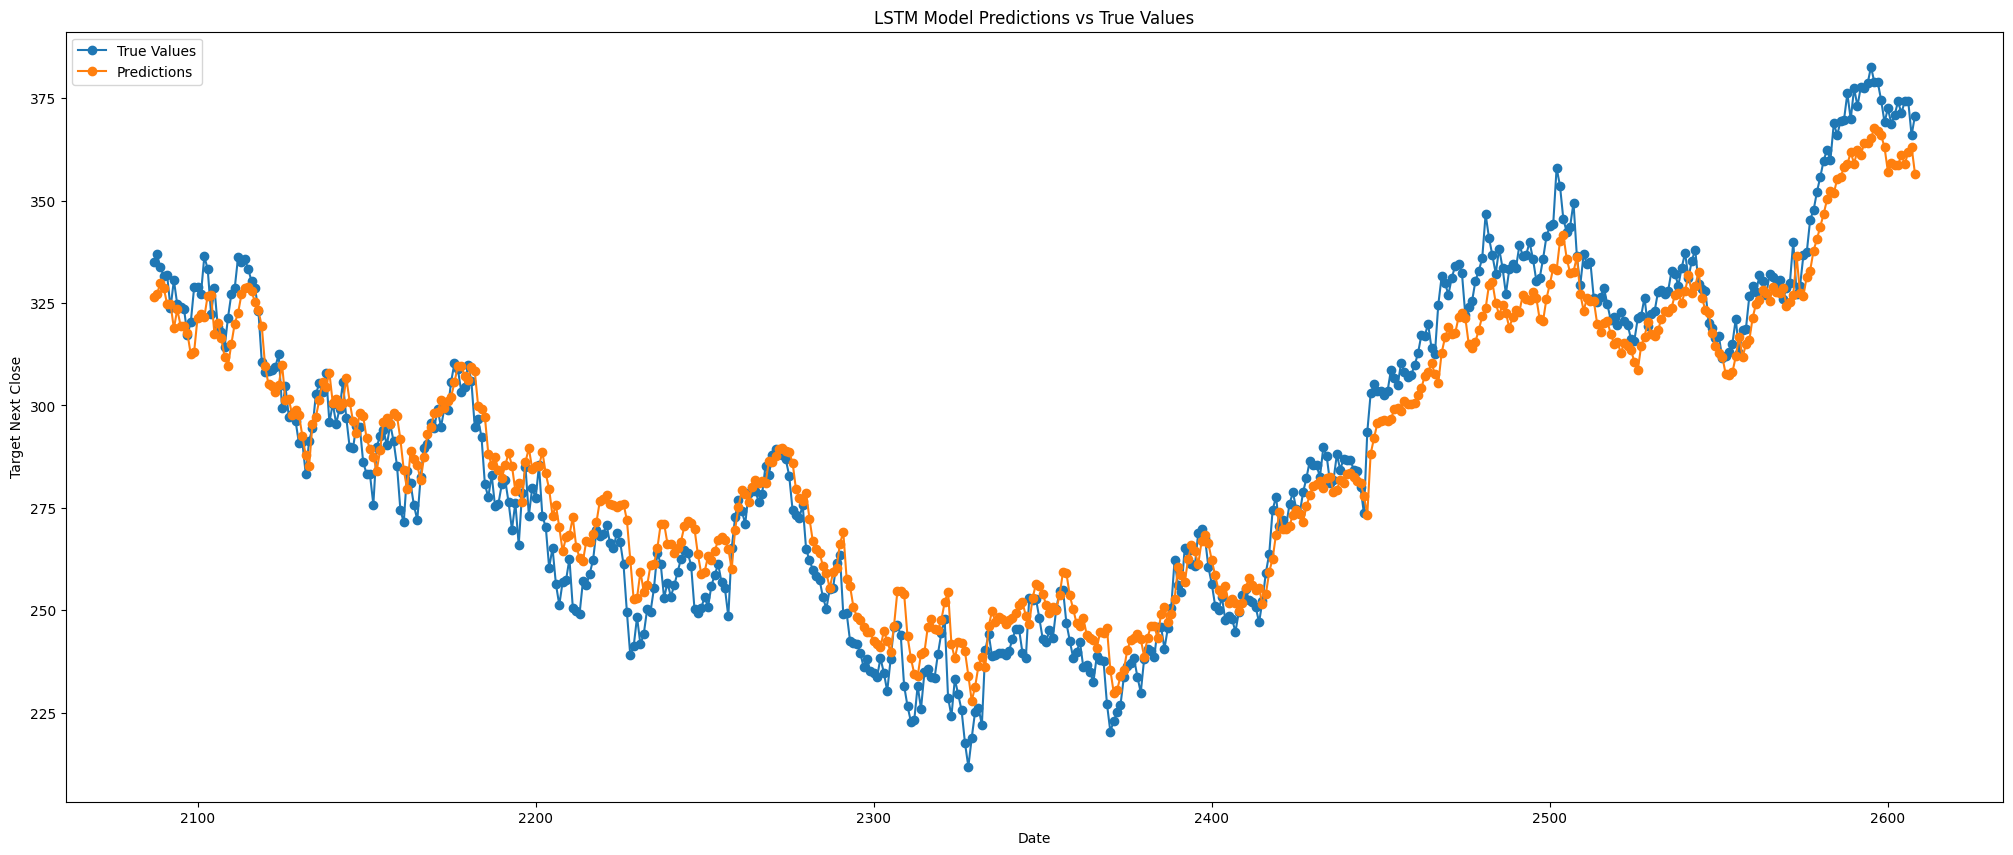

In [13]:
import matplotlib.pyplot as plt

# Assuming 'model' is your trained LSTM model
predictions = model.predict(test_features_lstm)

# Plotting
plt.figure(figsize=(25, 10))
plt.plot(test_targets.index, test_targets['target_next_close'], label='True Values', marker='o')
plt.plot(test_targets.index, predictions[:, 2], label='Predictions', marker='o')  # Assuming 'target_next_close' is the third column
plt.title('LSTM Model Predictions vs True Values')
plt.xlabel('Date')
plt.ylabel('Target Next Close')
plt.legend()
plt.show()


Epoch 1/50
66/66 [==============================] - 1s 12ms/step - loss: 3.9859 - val_loss: 39.4755
Epoch 2/50
66/66 [==============================] - 1s 11ms/step - loss: 3.9018 - val_loss: 38.8761
Epoch 3/50
66/66 [==============================] - 1s 12ms/step - loss: 3.8225 - val_loss: 38.6976
Epoch 4/50
66/66 [==============================] - 1s 11ms/step - loss: 3.7476 - val_loss: 39.2695
Epoch 5/50
66/66 [==============================] - 1s 12ms/step - loss: 3.6605 - val_loss: 38.2221
Epoch 6/50
66/66 [==============================] - 1s 12ms/step - loss: 3.5975 - val_loss: 38.9981
Epoch 7/50
66/66 [==============================] - 1s 12ms/step - loss: 3.5399 - val_loss: 39.7511
Epoch 8/50
66/66 [==============================] - 1s 11ms/step - loss: 3.4849 - val_loss: 39.2341
Epoch 9/50
66/66 [==============================] - 1s 11ms/step - loss: 3.4357 - val_loss: 39.0236
Epoch 10/50
66/66 [==============================] - 1s 11ms/step - loss: 3.3995 - val_loss: 39.8343

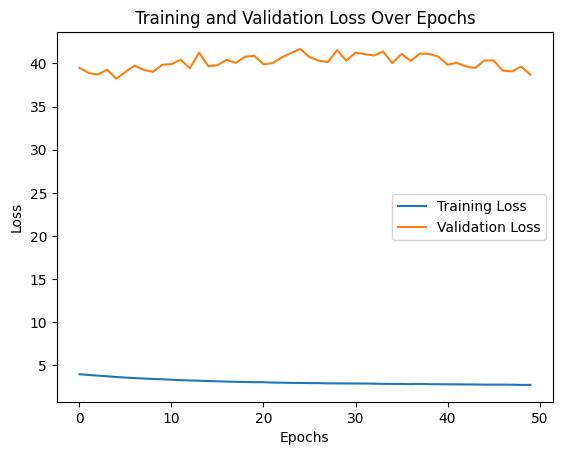

In [14]:
history = model.fit(train_features_lstm, train_targets, epochs=epochs, batch_size=batch_size, validation_data=(test_features_lstm, test_targets))

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

predictions = model.predict(test_features_lstm)
mae = mean_absolute_error(test_targets['target_next_close'], predictions[:, 2])  # Assuming 'target_next_close' is the third column
mse = mean_squared_error(test_targets['target_next_close'], predictions[:, 2])
rmse = np.sqrt(mse)

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')

17/17 [==============================] - 0s 4ms/step
MAE: 7.46
MSE: 84.12
RMSE: 9.17


In [16]:
from sklearn.metrics import accuracy_score

# Assuming 'target_class' is the classification target column
predictions_class = (predictions[:, 1] > 0.5).astype(int)
accuracy = accuracy_score(test_targets['target_class'], predictions_class)

print(f'Directional Accuracy: {accuracy:.2%}')

Directional Accuracy: 71.07%


### Grid Search 

In [17]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [22]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import Adam

# Function to create an LSTM model
def create_lstm_model(units=50, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=units, activation='relu', input_shape=(time_steps, numeric_features.shape[1])))
    model.add(Dense(units=3))  # Assuming you have 3 output columns
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Wrap the Keras model for use with GridSearchCV
lstm_regressor = KerasRegressor(learning_rate=0.001,build_fn=create_lstm_model, epochs=10, batch_size=32, units=50, verbose=0)

# Define hyperparameters to search
param_grid = {
    'units': [50, 100, 150],
    'learning_rate': [0.001, 0.01, 0.1]
}

# Perform Grid Search
grid_search = GridSearchCV(estimator=lstm_regressor, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')



In [23]:
grid_result = grid_search.fit(train_features_lstm, train_targets)

/Users/fauzanarif/Bootcamp/ds-capstone/.venv/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
2023-12-19 12:46:31.133670: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp_6.


/Users/fauzanarif/Bootcamp/ds-capstone/.venv/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


/Users/fauzanarif/Bootcamp/ds-capstone/.venv/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


/Users/fauzanarif/Bootcamp/ds-capstone/.venv/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


/Users/fauzanarif/Bootcamp/ds-capstone/.venv/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


/Users/fauzanarif/Bootcamp/ds-capstone/.venv/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
2023-12-19 12:47:33.761031: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp_6.


/Users/fauzanarif/Bootcamp/ds-capstone/.venv/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


/Users/fauzanarif/Bootcamp/ds-capstone/.venv/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


/Users/fauzanarif/Bootcamp/ds-capstone/.venv/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


/Users/fauzanarif/Bootcamp/ds-capstone/.venv/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


/Users/fauzanarif/Bootcamp/ds-capstone/.venv/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
2023-12-19 12:48:37.996774: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp_6.


/Users/fauzanarif/Bootcamp/ds-capstone/.venv/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


/Users/fauzanarif/Bootcamp/ds-capstone/.venv/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


/Users/fauzanarif/Bootcamp/ds-capstone/.venv/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


/Users/fauzanarif/Bootcamp/ds-capstone/.venv/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


/Users/fauzanarif/Bootcamp/ds-capstone/.venv/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
2023-12-19 12:49:42.386243: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp_6.


/Users/fauzanarif/Bootcamp/ds-capstone/.venv/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


/Users/fauzanarif/Bootcamp/ds-capstone/.venv/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


/Users/fauzanarif/Bootcamp/ds-capstone/.venv/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


/Users/fauzanarif/Bootcamp/ds-capstone/.venv/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


/Users/fauzanarif/Bootcamp/ds-capstone/.venv/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
2023-12-19 12:50:46.606233: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp_6.


/Users/fauzanarif/Bootcamp/ds-capstone/.venv/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


/Users/fauzanarif/Bootcamp/ds-capstone/.venv/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


/Users/fauzanarif/Bootcamp/ds-capstone/.venv/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


/Users/fauzanarif/Bootcamp/ds-capstone/.venv/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


/Users/fauzanarif/Bootcamp/ds-capstone/.venv/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
2023-12-19 12:51:54.547064: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp_6.


/Users/fauzanarif/Bootcamp/ds-capstone/.venv/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


/Users/fauzanarif/Bootcamp/ds-capstone/.venv/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


In [29]:
grid_search

GridSearchCV(cv=3,
             estimator=KerasRegressor(batch_size=32, build_fn=<function create_lstm_model at 0x29eaf0f40>, epochs=10, learning_rate=0.001, units=50, verbose=0),
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'units': [50, 100, 150]},
             scoring='neg_mean_squared_error')

In [24]:
best_params = grid_result.best_params_


In [26]:
best_model = create_lstm_model(units=best_params['units'], learning_rate=best_params['learning_rate'])


In [28]:
best_params

{'learning_rate': 0.1, 'units': 50}

In [31]:
best_model.fit(train_features_lstm, train_targets, epochs=epochs, batch_size=batch_size, verbose=1)


Epoch 1/50


2023-12-19 12:58:45.600798: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp_6.


66/66 [==============================] - 7s 42ms/step - loss: 677.4075
Epoch 2/50
66/66 [==============================] - 1s 13ms/step - loss: 6.9793
Epoch 3/50
66/66 [==============================] - 1s 13ms/step - loss: 4.3710
Epoch 4/50
66/66 [==============================] - 1s 13ms/step - loss: 4.0340
Epoch 5/50
66/66 [==============================] - 1s 13ms/step - loss: 3.9053
Epoch 6/50
66/66 [==============================] - 1s 14ms/step - loss: 3.7706
Epoch 7/50
66/66 [==============================] - 1s 13ms/step - loss: 3.8943
Epoch 8/50
66/66 [==============================] - 1s 13ms/step - loss: 3.3845
Epoch 9/50
66/66 [==============================] - 1s 13ms/step - loss: 4.3851
Epoch 10/50
66/66 [==============================] - 1s 13ms/step - loss: 3.5925
Epoch 11/50
66/66 [==============================] - 1s 13ms/step - loss: 3.2292
Epoch 12/50
66/66 [==============================] - 1s 13ms/step - loss: 3.5104
Epoch 13/50
66/66 [===========================

In [33]:
print("Best mean squared error found: ", -grid_result.best_score_)

Best mean squared error found:  8.473815019181961


In [34]:
grid_result

GridSearchCV(cv=3,
             estimator=KerasRegressor(batch_size=32, build_fn=<function create_lstm_model at 0x29eaf0f40>, epochs=10, learning_rate=0.001, units=50, verbose=0),
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'units': [50, 100, 150]},
             scoring='neg_mean_squared_error')

In [38]:
y_pred = grid_result.predict(test_features_lstm)
print("Mean Squared Error on test set: ", mean_squared_error(test_targets, y_pred))
print("R-squared on test set: ", r2_score(test_targets, y_pred))

Mean Squared Error on test set:  35.4751187784582
R-squared on test set:  0.0038315837378966786


In [42]:
best_model.save_weights("model.h5")